In [10]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import seaborn as sns
from io import BytesIO
import os
from importlib import reload
import src.models.curation_treatment as ct 
from sentence_transformers import util
reload(ct)


<module 'src.models.curation_treatment' from '/Users/abhilashdhal/Desktop/cbioportal_gsoc/OmicsMLRepoHarmonizer/src/models/curation_treatment.py'>

## 0. Current Matching algorithm work

## 1. Updated module for current algorithm

In [12]:
source_dir = "./"
map_url = os.path.join(source_dir, "data/cBioPortal_treatment_name_map.csv")
df = pd.read_csv(map_url)
df = df[["original_value", "curated_ontology", "curated_ontology_term_id"]]
orig_cura_map = dict(zip(df["original_value"], df["curated_ontology"]))
ct_instance = ct.CuraTreatment(cura_map=orig_cura_map, method='bert-base', from_tokenizer=False)
ct_instance_pubmed = ct.CuraTreatment(cura_map=orig_cura_map, method='pubmed-bert', from_tokenizer=False)

In [13]:
results_df_base_bert = ct_instance.get_match_results()
results_df_pubmed_bert = ct_instance_pubmed.get_match_results()


## 1. How many 1 to 1 and many to 1 matches of curated ontology to original values?

In [14]:
count_of_orig_to_curated = results_df_base_bert.groupby(['curated_ontology'])['original_value'].count().sort_values(ascending=False).reset_index()
count_of_orig_to_curated['mapping_type'] = count_of_orig_to_curated['original_value'].apply(lambda x: 'one_to_one' if x == 1 else 'many_to_one')
histplot_df = count_of_orig_to_curated.groupby(['mapping_type'])['original_value'].sum().reset_index()

In [15]:
count_of_orig_to_curated 

,curated_ontology,original_value,mapping_type
0,Cyclophosphamide,12,many_to_one
1,Fluorouracil,9,many_to_one
2,Pembrolizumab,9,many_to_one
3,Radical Cystoprostatectomy,9,many_to_one
4,Temozolomide,8,many_to_one
...,...,...,...
554,Immunoglobulin,1,one_to_one
555,Ifabotuzumab,1,one_to_one
556,Idasanutlin,1,one_to_one
557,IDO Inhibitor,1,one_to_one


In [16]:
histplot_df

,mapping_type,original_value
0,many_to_one,527
1,one_to_one,391


/opt/homebrew/anaconda3/envs/‘gsoc_harmon_2024’/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/envs/‘gsoc_harmon_2024’/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/‘gsoc_harmon_2024’/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 0, 'Mapping type')

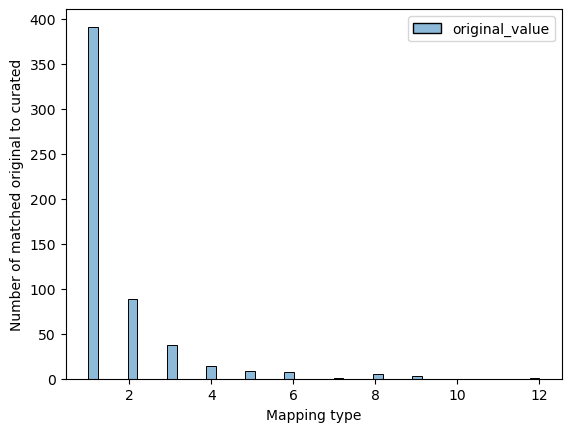

In [17]:
ax = sns.histplot(data = count_of_orig_to_curated.iloc[:, :2])
ax.set_ylabel('Number of matched original to curated')
ax.set_xlabel('Mapping type')

Text(0.5, 0, 'Mapping type')

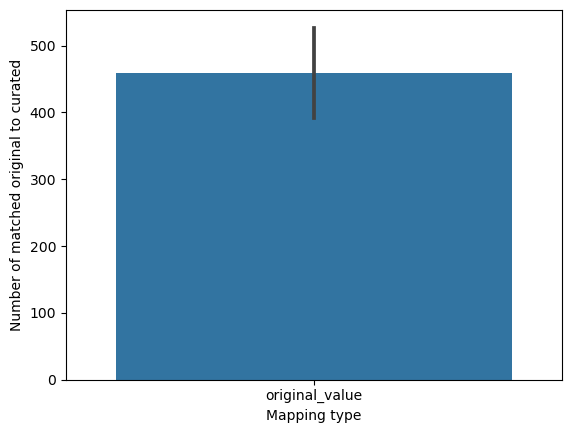

In [18]:
ax = sns.barplot(data = histplot_df)
ax.set_ylabel('Number of matched original to curated')
ax.set_xlabel('Mapping type')

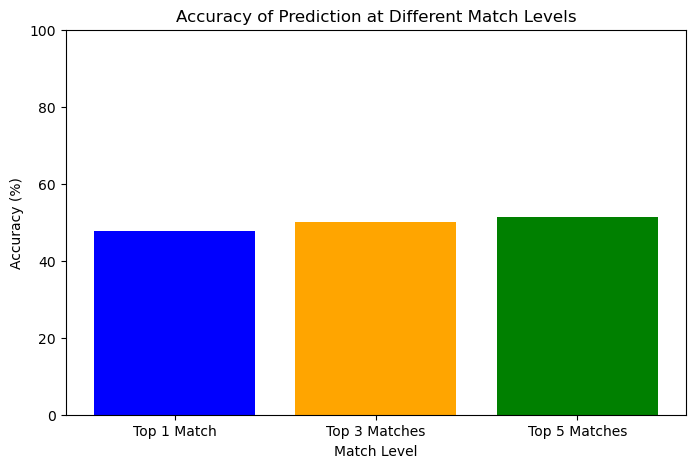

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset

# file_path = './outputs/cbio_treatment_name/trt_name_match_from_curated.csv'
data = results_df_base_bert

# Calculate accuracy for Top 1, Top 3, and Top 5 matches
data['top1_accuracy'] = data.apply(lambda row: row['curated_ontology'] == row['top1_match'], axis=1)
data['top3_accuracy'] = data.apply(lambda row: row['curated_ontology'] in row[['top1_match', 'top2_match', 'top3_match']].values, axis=1)
data['top5_accuracy'] = data.apply(lambda row: row['curated_ontology'] in row[['top1_match', 'top2_match', 'top3_match', 'top4_match', 'top5_match']].values, axis=1)

# Calculate percentage accuracies
top1_accuracy = data['top1_accuracy'].mean() * 100
top3_accuracy = data['top3_accuracy'].mean() * 100
top5_accuracy = data['top5_accuracy'].mean() * 100

# Prepare data for plotting
accuracy_data = {
    'Accuracy Level': ['Top 1 Match', 'Top 3 Matches', 'Top 5 Matches'],
    'Accuracy': [top1_accuracy, top3_accuracy, top5_accuracy]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(accuracy_df['Accuracy Level'], accuracy_df['Accuracy'], color=['blue', 'orange', 'green'])
plt.xlabel('Match Level')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Prediction at Different Match Levels')
plt.ylim(0, 100)
plt.show()

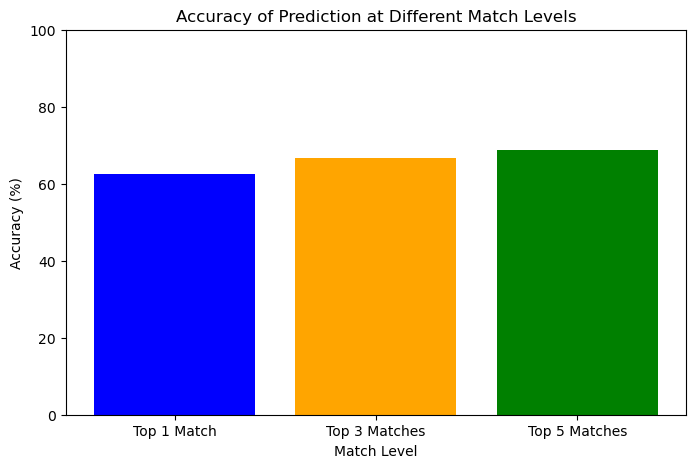

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset

# file_path = './outputs/cbio_treatment_name/trt_name_match_from_curated.csv'
data = results_df_pubmed_bert

# Calculate accuracy for Top 1, Top 3, and Top 5 matches
data['top1_accuracy'] = data.apply(lambda row: row['curated_ontology'] == row['top1_match'], axis=1)
data['top3_accuracy'] = data.apply(lambda row: row['curated_ontology'] in row[['top1_match', 'top2_match', 'top3_match']].values, axis=1)
data['top5_accuracy'] = data.apply(lambda row: row['curated_ontology'] in row[['top1_match', 'top2_match', 'top3_match', 'top4_match', 'top5_match']].values, axis=1)

# Calculate percentage accuracies
top1_accuracy = data['top1_accuracy'].mean() * 100
top3_accuracy = data['top3_accuracy'].mean() * 100
top5_accuracy = data['top5_accuracy'].mean() * 100

# Prepare data for plotting
accuracy_data = {
    'Accuracy Level': ['Top 1 Match', 'Top 3 Matches', 'Top 5 Matches'],
    'Accuracy': [top1_accuracy, top3_accuracy, top5_accuracy]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(accuracy_df['Accuracy Level'], accuracy_df['Accuracy'], color=['blue', 'orange', 'green'])
plt.xlabel('Match Level')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Prediction at Different Match Levels')
plt.ylim(0, 100)
plt.show()

## 2. Testing sentence transformers and language models in a single module

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import seaborn as sns
from io import BytesIO
import os
from importlib import reload
import src.models.curation_treatment as ct 
from sentence_transformers import util
reload(ct)

# tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer")
# model = AutoModel.from_pretrained("yikuan8/Clinical-Longformer")

/opt/homebrew/anaconda3/envs/‘gsoc_harmon_2024’/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.models.curation_treatment' from '/Users/abhilashdhal/Desktop/cbioportal_gsoc/OmicsMLRepoHarmonizer/src/models/curation_treatment.py'>

## 2.1. Testing working of sentence transformer models first

1. Test initialization 
2. Test embedding generation 
3. Test semantics similarity mapping
4. Combined function for all three functions in a get_match_results

In [ ]:
source_dir = "./"
map_url = os.path.join(source_dir, "data/cBioPortal_treatment_name_map.csv")
df = pd.read_csv(map_url)
df = df[["original_value", "curated_ontology", "curated_ontology_term_id"]]
orig_cura_map = dict(zip(df["original_value"], df["curated_ontology"]))
ct_instance = ct.CuraTreatment(cura_map=orig_cura_map, method='bert-base', from_tokenizer=False)
ct_instance_pubmed = ct.CuraTreatment(cura_map=orig_cura_map, method='pubmed-bert', from_tokenizer=False)

In [ ]:
results_df_base_bert = ct_instance.get_match_results()
results_df_pubmed_bert = ct_instance_pubmed.get_match_results()


In [ ]:
ct_instance.method_model_dict

{'bert-base': 'bert-base-nli-mean-tokens',
 'pubmed-bert': 'pritamdeka/S-PubMedBert-MS-MARCO',
 'bio-bert': 'dmis-lab/biobert-v1.1',
 'longformer': 'yikuan8/Clinical-Longformer',
 'big-bird': 'yikuan8/Clinical-BigBird'}

## 2.2 Testing working of language model 

1. Test initialization 
2. Test embedding generation 
3. Test semantics similarity mapping
4. Combined function for all three functions in a get_match_results

In [ ]:
ct_instance_lf = ct.CuraTreatment(cura_map=orig_cura_map, method='longformer', from_tokenizer=False)

In [ ]:
results_df_lf = ct_instance_lf.get_match_results(top_k=5)

No sentence-transformers model found with name yikuan8/Clinical-Longformer. Creating a new one with MEAN pooling.
Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Input ids are automatically padded from 17 to 512 to be a multiple of `config.attention_window`: 512


KeyboardInterrupt: 